# Working with Pytrees

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/google/jax/blob/main/docs/jax-101/05.1-pytrees.ipynb)

*Author: Vladimir Mikulik*

Often, we want to operate on objects that look like dicts of arrays, or lists of lists of dicts, or other nested structures. In JAX, we refer to these as *pytrees*, but you can sometimes see them called *nests*, or just *trees*.

JAX has built-in support for such objects, both in its library functions as well as through the use of functions from [`jax.tree_utils`](https://jax.readthedocs.io/en/latest/jax.tree_util.html) (with the most common ones also available as `jax.tree_*`). This section will explain how to use them, give some useful snippets and point out common gotchas.

## What is a pytree?

As defined in the [JAX pytree docs](https://jax.readthedocs.io/en/latest/pytrees.html):

> a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.

Some example pytrees:

In [1]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7e03ff991df0>]   has 3 leaves: [1, 'a', <object object at 0x7e03ff991df0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


We've also introduced our first `jax.tree_*` function, which allowed us to extract the flattened leaves from the trees.

## Why pytrees?

In machine learning, some places where you commonly find pytrees are:
* Model parameters
* Dataset entries
* RL agent observations

They also often arise naturally when working in bulk with datasets (e.g., lists of lists of dicts).

## Common pytree functions
Perhaps the most commonly used pytree function is `jax.tree_map`. It works analogously to Python's native `map`, but on entire pytrees:

In [2]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

`jax.tree_map` also works with multiple arguments:

In [4]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

When using multiple arguments with `jax.tree_map`, the structure of the inputs must exactly match. That is, lists must have the same number of elements, dicts must have the same keys, etc.

## Example: ML model parameters

A simple example of training an MLP displays some ways in which pytree operations come in useful:

In [5]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

We can use `jax.tree_map` to check that the shapes of our parameters are what we expect:

In [6]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [8]:
leaves = jax.tree_util.tree_leaves(params)

In [10]:
len(leaves)

6

Now, let's train our MLP:

In [11]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):

  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of the many JAX functions that has
  # built-in support for pytrees.

  # This is handy, because we can apply the SGD update using tree utils:
  return jax.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

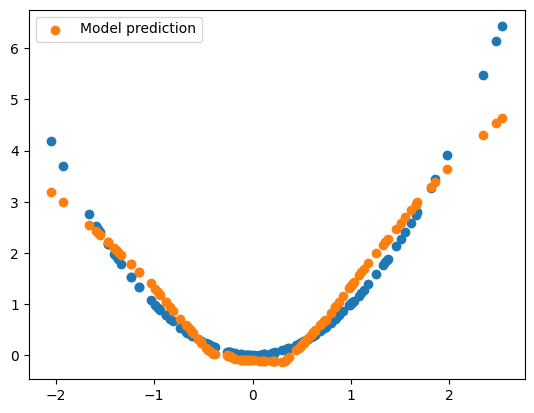

In [12]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

## Key paths

In a pytree each leaf has a _key path_. A key path for a leaf is a `list` of _keys_, where the length of the list is equal to the depth of the leaf in the pytree . Each _key_ is a [hashable object](https://docs.python.org/3/glossary.html#term-hashable) that represents an index into the corresponding pytree node type. The type of the key depends on the pytree node type; for example, the type of keys for `dict`s is different from the type of keys for `tuple`s.

For built-in pytree node types, the set of keys for any pytree node instance is unique. For a pytree comprising nodes with this property, the key path for each leaf is unique.

The APIs for working with key paths are:

* [`jax.tree_util.tree_flatten_with_path`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_flatten_with_path.html): Works similarly with `jax.tree_util.tree_flatten`, but returns key paths.

* [`jax.tree_util.tree_map_with_path`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_map_with_path.html): Works similarly with `jax.tree_util.tree_map`, but the function also takes key paths as arguments.

* [`jax.tree_util.keystr`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.keystr.html): Given a general key path, returns a reader-friendly string expression.

One use case is to print debugging information related to a certain leaf value:

In [16]:
import collections
ATuple = collections.namedtuple("ATuple", ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
for key_path, value in flattened:
    # print(key_path)
    print(f'Value of tree{jax.tree_util.keystr(key_path)}: {value}')

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


To express key paths, JAX provides a few default key types for the built-in pytree node types, namely:

*  `SequenceKey(idx: int)`: for lists and tuples.
*  `DictKey(key: Hashable)`: for dictionaries.
*  `GetAttrKey(name: str)`: for `namedtuple`s and preferrably custom pytree nodes (more in the next section)

You are free to define your own key types for your own custom nodes. They will work with `jax.tree_util.keystr` as long as their `__str__()` method is also overriden with a reader-friendly expression.

In [17]:
for key_path, _ in flattened:
    print(f'Key path of tree{jax.tree_util.keystr(key_path)}: {repr(key_path)}')

Key path of tree[0]: (SequenceKey(idx=0),)
Key path of tree[1]['k1']: (SequenceKey(idx=1), DictKey(key='k1'))
Key path of tree[1]['k2'][0]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0))
Key path of tree[1]['k2'][1]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1))
Key path of tree[2].name: (SequenceKey(idx=2), GetAttrKey(name='name'))


## Custom pytree nodes

So far, we've only been considering pytrees of lists, tuples, and dicts; everything else is considered a leaf. Therefore, if you define your own container class, it will be considered a leaf, even if it has trees inside it:

In [19]:
class MyContainer:
  """A named container."""

  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [20]:
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

Accordingly, if we try to use a tree map expecting our leaves to be the elements inside the container, we will get an error:

In [21]:
try:
    jax.tree_map(lambda x: x + 1, [
        MyContainer('Alice', 1, 2, 3),
        MyContainer('Bob', 4, 5, 6)
    ])
except TypeError as e:
    print(f'TypeError: {e}')

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'


To solve this, we need to register our container with JAX by telling it how to flatten and unflatten it:

In [22]:
from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

Alternatively, using the key path API mentioned above, you can register this container with its keys in mind by defining how the keys should look like for each flattened-out value.

In [23]:
class MyKeyPathContainer(MyContainer):
  pass

def flatten_with_keys_MyKeyPathContainer(container) -> tuple[Iterable[int], str]:
  """Returns an iterable over container contents, and aux data."""

  # GetAttrKey is a common way to express an attribute key. Users are free
  # to pick any other expression that fits their use cases the best.
  flat_contents = [(jax.tree_util.GetAttrKey('a'), container.a),
                   (jax.tree_util.GetAttrKey('b'), container.b),
                   (jax.tree_util.GetAttrKey('c'), container.c)]

  # we don't want the name to appear as a child, so it is auxiliary data.
  # auxiliary data is usually a description of the structure of a node,
  # e.g., the keys of a dict -- anything that isn't a node's children.
  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyKeyPathContainer(
    aux_data: str, flat_contents: Iterable[int]) -> MyKeyPathContainer:
  """Converts aux data and the flat contents into a MyContainer."""
  return MyKeyPathContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_with_keys(
    MyKeyPathContainer, flatten_with_keys_MyKeyPathContainer, unflatten_MyKeyPathContainer)

jax.tree_util.tree_leaves([
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

`register_pytree_with_keys` is an extended API of `register_pytree_node`, and containers registered in either way can freely use all the `tree_util` utilities without error.

When a container registered with `register_pytree_node` uses `.*_with_path` APIs, the keys being returned will be a series of "flat index" fallbacks:

In [24]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyContainer container{jax.tree_util.keystr(key_path)}: {value}')

flattened, _ = jax.tree_util.tree_flatten_with_path(MyKeyPathContainer('Alice', 1, 2, 3))
for key_path, value in flattened:
    print(f'MyKeyPathContainer container{jax.tree_util.keystr(key_path)}: {value}')

MyContainer container[<flat index 0>]: 1
MyContainer container[<flat index 1>]: 2
MyContainer container[<flat index 2>]: 3
MyKeyPathContainer container.a: 1
MyKeyPathContainer container.b: 2
MyKeyPathContainer container.c: 3


Modern Python comes equipped with helpful tools to make defining containers easier. Some of these will work with JAX out-of-the-box, but others require more care. For instance, a `NamedTuple` subclass doesn't need to be registered to be considered a pytree node type:

In [25]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

# Since `tuple` is already registered with JAX, and NamedTuple is a subclass,
# this will work out-of-the-box:
jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6)
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

Notice that the `name` field now appears as a leaf, as all tuple elements are children. That's the price we pay for not having to register the class the hard way.

## Common pytree gotchas and patterns

### Gotchas
#### Mistaking nodes for leaves
A common problem to look out for is accidentally introducing tree nodes instead of leaves:

In [26]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)),
 (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]

What happened is that the `shape` of an array is a tuple, which is a pytree node, with its elements as leaves. Thus, in the map, instead of calling `jnp.ones` on e.g. `(2, 3)`, it's called on `2` and `3`.

The solution will depend on the specifics, but there are two broadly applicable options:
* rewrite the code to avoid the intermediate `tree_map`.
* convert the tuple into an `np.array` or `jnp.array`, which makes the entire
sequence a leaf.

#### Handling of None
`jax.tree_utils` treats `None` as a node without children, not as a leaf:

In [27]:
jax.tree_util.tree_leaves([None, None, None])

[]

### Patterns
#### Transposing trees

If you would like to transpose a pytree, i.e. turn a list of trees into a tree of lists, you can do so using `jax.tree_map`:

In [28]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)


# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

For more complicated transposes, JAX provides `jax.tree_transpose`, which is more verbose, but allows you specify the structure of the inner and outer Pytree for more flexibility:

In [31]:
jax.tree_transpose(
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
  inner_treedef = jax.tree_structure(episode_steps[0]),
  pytree_to_transpose = episode_steps
)

<ipython-input-31-b976dc49db02>:2: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
<ipython-input-31-b976dc49db02>:3: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  inner_treedef = jax.tree_structure(episode_steps[0]),
<ipython-input-31-b976dc49db02>:1: FutureWarning: jax.tree_transpose is deprecated, and will be removed in a future release. Use jax.tree_util.tree_transpose instead.
  jax.tree_transpose(


{'obs': [3, 4], 't': [1, 2]}

## More Information

For more information on pytrees in JAX and the operations that are available, see the [Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html) section in the JAX documentation.